<a href="https://colab.research.google.com/github/afrin764/AdenoAssosiationVirus/blob/main/supervisd_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
Resnet

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Total images: 693
Classes: ['Double' 'Empty' 'Single']


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:30: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]


Extracting features using RESNET...
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 109s 6s/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 36s 7s/step

Training SVM with RESNET features...
 SVM Accuracy: 89.21% | Precision: 0.89 | Recall: 0.88 | F1: 0.88
Confusion matrix saved to /content/drive/MyDrive/confusion_matrices/RESNET_SVM_confusion_matrix.png


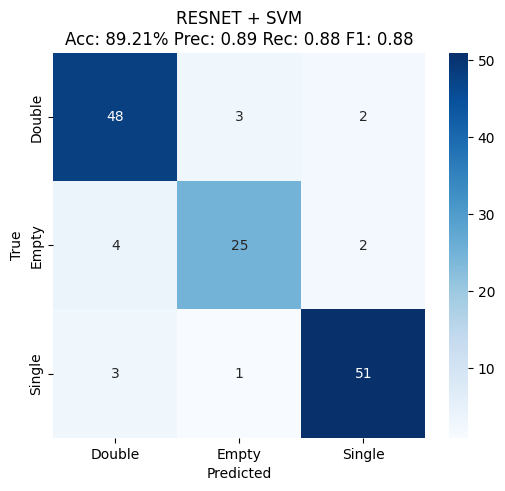


Confusion Matrix:
 [[48  3  2]
 [ 4 25  2]
 [ 3  1 51]]

Classification Report:
               precision    recall  f1-score   support

      Double       0.87      0.91      0.89        53
       Empty       0.86      0.81      0.83        31
      Single       0.93      0.93      0.93        55

    accuracy                           0.89       139
   macro avg       0.89      0.88      0.88       139
weighted avg       0.89      0.89      0.89       139


Training MLP with RESNET features...
 MLP Accuracy: 92.09% | Precision: 0.91 | Recall: 0.92 | F1: 0.92
Confusion matrix saved to /content/drive/MyDrive/confusion_matrices/RESNET_MLP_confusion_matrix.png


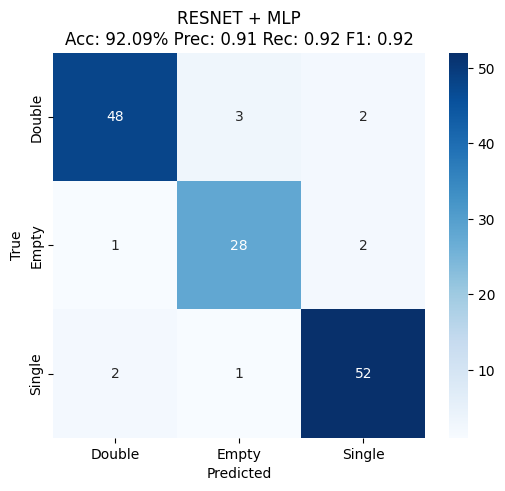


Confusion Matrix:
 [[48  3  2]
 [ 1 28  2]
 [ 2  1 52]]

Classification Report:
               precision    recall  f1-score   support

      Double       0.94      0.91      0.92        53
       Empty       0.88      0.90      0.89        31
      Single       0.93      0.95      0.94        55

    accuracy                           0.92       139
   macro avg       0.91      0.92      0.92       139
weighted avg       0.92      0.92      0.92       139


Training RandomForest with RESNET features...
 RandomForest Accuracy: 85.61% | Precision: 0.87 | Recall: 0.84 | F1: 0.85
Confusion matrix saved to /content/drive/MyDrive/confusion_matrices/RESNET_RandomForest_confusion_matrix.png


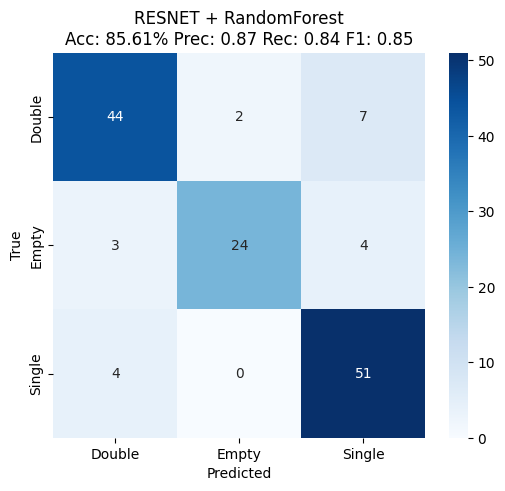


Confusion Matrix:
 [[44  2  7]
 [ 3 24  4]
 [ 4  0 51]]

Classification Report:
               precision    recall  f1-score   support

      Double       0.86      0.83      0.85        53
       Empty       0.92      0.77      0.84        31
      Single       0.82      0.93      0.87        55

    accuracy                           0.86       139
   macro avg       0.87      0.84      0.85       139
weighted avg       0.86      0.86      0.86       139


 Metrics Summary:

    Model    Classifier  Accuracy  Precision    Recall  F1-Score
0  RESNET           SVM  0.892086   0.887356  0.879795  0.883165
1  RESNET           MLP  0.920863   0.914916  0.918114  0.916301
2  RESNET  RandomForest  0.856115   0.869468  0.843885  0.853351

 Metrics summary CSV saved to /content/drive/MyDrive/confusion_matrices/RESNET_metrics_summary.csv


In [ ]:
# Install dependencies
!pip install transformers tensorflow scikit-learn opencv-python matplotlib seaborn --quiet

#Imports
from transformers import ViTFeatureExtractor, ViTModel
import torch
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, VGG16, MobileNetV3Large
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input as mobilenet_preprocess
from tensorflow.keras.models import Model

from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score,
                             recall_score, f1_score, classification_report)
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import cv2
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Dataset Path (update path)
dataset_path = '/content/drive/MyDrive/100_4strain_val_photos'

#Load Dataset
img_size = (224, 224)
X, y = [], []

for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(root, file)
            label = os.path.basename(root)
            img = cv2.imread(img_path)
            img = cv2.resize(img, img_size)
            X.append(img)
            y.append(label)

X = np.array(X)
y = np.array(y)

print("Total images:", len(X))
print("Classes:", np.unique(y))

#Encode Labels and Split
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_val, y_train, y_val = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Feature Extraction Functions
vit_feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
vit_model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')

def extract_vit_features(X_data):
    inputs = vit_feature_extractor(images=[cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in X_data], return_tensors="pt")
    with torch.no_grad():
        outputs = vit_model(**inputs)
    return outputs.last_hidden_state[:, 0, :].numpy()

def extract_features(model_name, X_data):
    if model_name == 'resnet':
        base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')
        X_data = resnet_preprocess(X_data.copy())
        model = Model(inputs=base_model.input, outputs=base_model.output)
        features = model.predict(X_data, batch_size=32, verbose=1)
    elif model_name == 'vgg16':
        base_model = VGG16(weights='imagenet', include_top=False, pooling='avg')
        X_data = vgg_preprocess(X_data.copy())
        model = Model(inputs=base_model.input, outputs=base_model.output)
        features = model.predict(X_data, batch_size=32, verbose=1)
    elif model_name == 'mobilenet':
        base_model = MobileNetV3Large(weights='imagenet', include_top=False, pooling='avg')
        X_data = mobilenet_preprocess(X_data.copy())
        model = Model(inputs=base_model.input, outputs=base_model.output)
        features = model.predict(X_data, batch_size=32, verbose=1)
    elif model_name == 'vit':
        features = extract_vit_features(X_data)
    else:
        raise ValueError("Invalid model name")
    return features

#Folder to save confusion matrices
save_folder = '/content/drive/MyDrive/confusion_matrices'
os.makedirs(save_folder, exist_ok=True)

#Choose model: 'resnet' | 'vgg16' | 'mobilenet' | 'vit'
model_choice = 'resnet'

print(f"\nExtracting features using {model_choice.upper()}...")
train_features = extract_features(model_choice, X_train)
val_features = extract_features(model_choice, X_val)

#Classifiers
classifiers = {
    "SVM": SVC(kernel='linear', probability=True),
    "MLP": MLPClassifier(hidden_layer_sizes=(256, 128), max_iter=500),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42)
}

# DataFrame to store metrics
metrics_list = []

#Training and Confusion Matrix Generation
for clf_name, clf in classifiers.items():
    print(f"\nTraining {clf_name} with {model_choice.upper()} features...")
    clf.fit(train_features, y_train)
    y_pred = clf.predict(val_features)

    # Metrics
    acc = accuracy_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_val, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_val, y_pred, average='macro', zero_division=0)

    print(f" {clf_name} Accuracy: {acc*100:.2f}% | Precision: {prec:.2f} | Recall: {rec:.2f} | F1: {f1:.2f}")

    #  Save metrics
    metrics_list.append({
        'Model': model_choice.upper(),
        'Classifier': clf_name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1
    })

    #  Confusion Matrix
    cm = confusion_matrix(y_val, y_pred)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title(f'{model_choice.upper()} + {clf_name}\nAcc: {acc*100:.2f}% Prec: {prec:.2f} Rec: {rec:.2f} F1: {f1:.2f}')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Save confusion matrix image
    filename = f'{model_choice.upper()}_{clf_name}_confusion_matrix.png'
    save_path = os.path.join(save_folder, filename)
    plt.savefig(save_path, bbox_inches='tight')
    print(f"Confusion matrix saved to {save_path}")

    plt.show()

    # Print confusion matrix numbers
    print("\nConfusion Matrix:\n", cm)
    print("\nClassification Report:\n", classification_report(y_val, y_pred, target_names=label_encoder.classes_))

# Metrics Summary DataFrame
metrics_df = pd.DataFrame(metrics_list)
print("\n Metrics Summary:\n")
print(metrics_df)

#  Save metrics summary as CSV
metrics_csv_path = os.path.join(save_folder, f'{model_choice.upper()}_metrics_summary.csv')
metrics_df.to_csv(metrics_csv_path, index=False)
print(f"\n Metrics summary CSV saved to {metrics_csv_path}")


In [ ]:
mobilenet

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Total images: 693
Classes: ['Double' 'Empty' 'Single']


/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:30: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(



Extracting features using MOBILENET...
18/18 [==============================] - 25s 1s/step


5/5 [==============================] - 9s 1s/step

Training SVM with MOBILENET features...
✅ SVM Accuracy: 90.65% | Precision: 0.91 | Recall: 0.90 | F1: 0.90
 Confusion matrix saved to /content/drive/MyDrive/confusion_matrices/MOBILENET_SVM_confusion_matrix.png


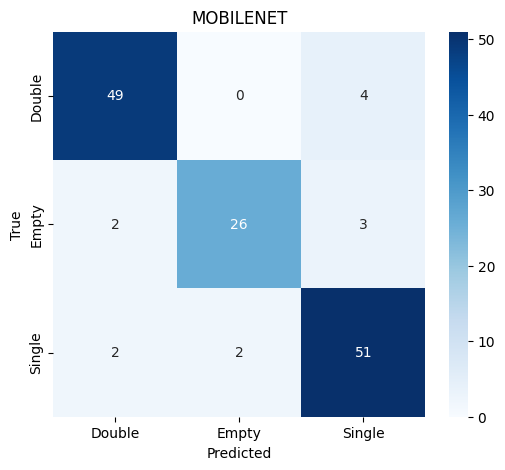


Confusion Matrix:
 [[49  0  4]
 [ 2 26  3]
 [ 2  2 51]]

Classification Report:
               precision    recall  f1-score   support

      Double       0.92      0.92      0.92        53
       Empty       0.93      0.84      0.88        31
      Single       0.88      0.93      0.90        55

    accuracy                           0.91       139
   macro avg       0.91      0.90      0.90       139
weighted avg       0.91      0.91      0.91       139


Training MLP with MOBILENET features...
✅ MLP Accuracy: 91.37% | Precision: 0.91 | Recall: 0.91 | F1: 0.91
 Confusion matrix saved to /content/drive/MyDrive/confusion_matrices/MOBILENET_MLP_confusion_matrix.png


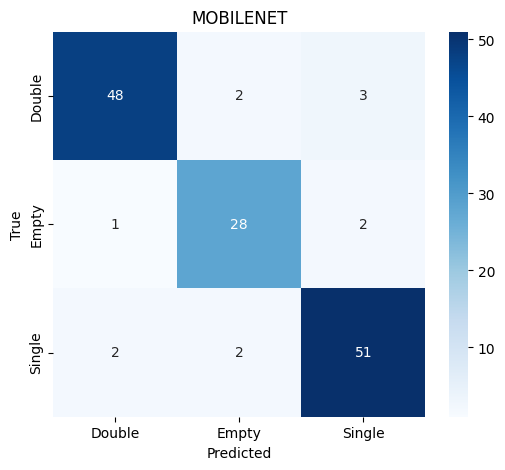


Confusion Matrix:
 [[48  2  3]
 [ 1 28  2]
 [ 2  2 51]]

Classification Report:
               precision    recall  f1-score   support

      Double       0.94      0.91      0.92        53
       Empty       0.88      0.90      0.89        31
      Single       0.91      0.93      0.92        55

    accuracy                           0.91       139
   macro avg       0.91      0.91      0.91       139
weighted avg       0.91      0.91      0.91       139


Training RandomForest with MOBILENET features...
✅ RandomForest Accuracy: 80.58% | Precision: 0.80 | Recall: 0.78 | F1: 0.79
 Confusion matrix saved to /content/drive/MyDrive/confusion_matrices/MOBILENET_RandomForest_confusion_matrix.png


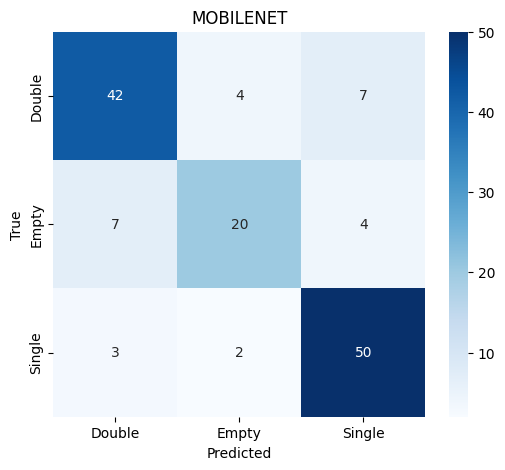


Confusion Matrix:
 [[42  4  7]
 [ 7 20  4]
 [ 3  2 50]]

Classification Report:
               precision    recall  f1-score   support

      Double       0.81      0.79      0.80        53
       Empty       0.77      0.65      0.70        31
      Single       0.82      0.91      0.86        55

    accuracy                           0.81       139
   macro avg       0.80      0.78      0.79       139
weighted avg       0.80      0.81      0.80       139


 Metrics Summary:

       Model    Classifier  Accuracy  Precision    Recall  F1-Score
0  MOBILENET           SVM  0.906475   0.910803  0.896837  0.902846
1  MOBILENET           MLP  0.913669   0.908964  0.912053  0.910295
2  MOBILENET  RandomForest  0.805755   0.798865  0.782235  0.787941

 Metrics summary CSV saved to /content/drive/MyDrive/confusion_matrices/MOBILENET_metrics_summary.csv


In [ ]:
#  Install dependencies
!pip install transformers tensorflow scikit-learn opencv-python matplotlib seaborn --quiet

# Imports
from transformers import ViTFeatureExtractor, ViTModel
import torch
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, VGG16, MobileNetV3Large
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input as mobilenet_preprocess
from tensorflow.keras.models import Model

from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score,
                             recall_score, f1_score, classification_report)
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import cv2
from google.colab import drive

#  Mount Google Drive
drive.mount('/content/drive')

#  Dataset Path
dataset_path = '/content/drive/MyDrive/100_4strain_val_photos'

#  Load Dataset
img_size = (224, 224)
X, y = [], []

for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(root, file)
            label = os.path.basename(root)
            img = cv2.imread(img_path)
            img = cv2.resize(img, img_size)
            X.append(img)
            y.append(label)

X = np.array(X)
y = np.array(y)

print("Total images:", len(X))
print("Classes:", np.unique(y))

#  Encode Labels and Split
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_val, y_train, y_val = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

#  Feature Extraction Functions
vit_feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
vit_model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')

def extract_vit_features(X_data):
    inputs = vit_feature_extractor(images=[cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in X_data], return_tensors="pt")
    with torch.no_grad():
        outputs = vit_model(**inputs)
    return outputs.last_hidden_state[:, 0, :].numpy()

def extract_features(model_name, X_data):
    if model_name == 'resnet':
        base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')
        X_data = resnet_preprocess(X_data.copy())
        model = Model(inputs=base_model.input, outputs=base_model.output)
        features = model.predict(X_data, batch_size=32, verbose=1)
    elif model_name == 'vgg16':
        base_model = VGG16(weights='imagenet', include_top=False, pooling='avg')
        X_data = vgg_preprocess(X_data.copy())
        model = Model(inputs=base_model.input, outputs=base_model.output)
        features = model.predict(X_data, batch_size=32, verbose=1)
    elif model_name == 'mobilenet':
        base_model = MobileNetV3Large(weights='imagenet', include_top=False, pooling='avg')
        X_data = mobilenet_preprocess(X_data.copy())
        model = Model(inputs=base_model.input, outputs=base_model.output)
        features = model.predict(X_data, batch_size=32, verbose=1)
    elif model_name == 'vit':
        features = extract_vit_features(X_data)
    else:
        raise ValueError("Invalid model name")
    return features

#  Folder to save confusion matrices
save_folder = '/content/drive/MyDrive/confusion_matrices'
os.makedirs(save_folder, exist_ok=True)

#  Choose the model: 'resnet' | 'vgg16' | 'mobilenet' | 'vit'
#model_choice = 'resnet'  # Change to 'vgg16', 'mobilenet', or 'vit' as needed
#model_choice = 'vgg16'
model_choice = 'mobilenet'
#model_choice = 'vit'

print(f"\nExtracting features using {model_choice.upper()}...")
train_features = extract_features(model_choice, X_train)
val_features = extract_features(model_choice, X_val)

#  Classifiers
classifiers = {
    "SVM": SVC(kernel='linear', probability=True),
    "MLP": MLPClassifier(hidden_layer_sizes=(256, 128), max_iter=500),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42)
}

# DataFrame to store metrics
metrics_list = []

#Training and Confusion Matrix Generation
for clf_name, clf in classifiers.items():
    print(f"\nTraining {clf_name} with {model_choice.upper()} features...")
    clf.fit(train_features, y_train)
    y_pred = clf.predict(val_features)

    # Metrics
    acc = accuracy_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_val, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_val, y_pred, average='macro', zero_division=0)

    print(f"{clf_name} Accuracy: {acc*100:.2f}% | Precision: {prec:.2f} | Recall: {rec:.2f} | F1: {f1:.2f}")

    #  Save metrics
    metrics_list.append({
        'Model': model_choice.upper(),
        'Classifier': clf_name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1
    })

    #  Confusion Matrix
    cm = confusion_matrix(y_val, y_pred)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title(f'{model_choice.upper()}')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    #  Save confusion matrix image
    filename = f'{model_choice.upper()}_{clf_name}_confusion_matrix.png'
    save_path = os.path.join(save_folder, filename)
    plt.savefig(save_path, bbox_inches='tight')
    print(f" Confusion matrix saved to {save_path}")

    plt.show()

    #  Print confusion matrix numbers
    print("\nConfusion Matrix:\n", cm)
    print("\nClassification Report:\n", classification_report(y_val, y_pred, target_names=label_encoder.classes_))

#  Metrics Summary DataFrame
metrics_df = pd.DataFrame(metrics_list)
print("\n Metrics Summary:\n")
print(metrics_df)

#Save metrics summary as CSV
metrics_csv_path = os.path.join(save_folder, f'{model_choice.upper()}_metrics_summary.csv')
metrics_df.to_csv(metrics_csv_path, index=False)
print(f"\n Metrics summary CSV saved to {metrics_csv_path}")


In [ ]:
vit

Mounted at /content/drive
Total images: 693
Classes: ['Double' 'Empty' 'Single']


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:30: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]


Extracting features using VIT...

Training SVM with VIT features...
 SVM Accuracy: 88.49% | Precision: 0.89 | Recall: 0.86 | F1: 0.87
 Confusion matrix saved to /content/drive/MyDrive/confusion_matrices/VIT_SVM_confusion_matrix.png


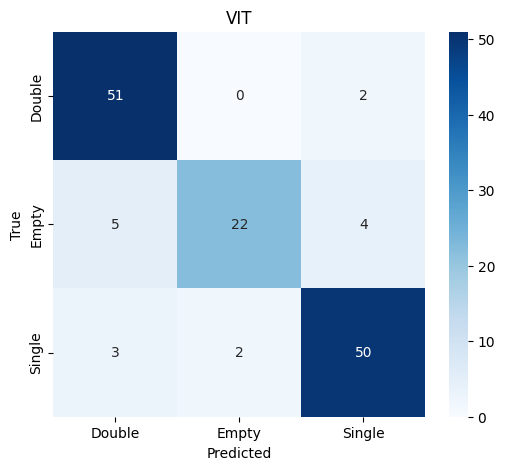


Confusion Matrix:
 [[51  0  2]
 [ 5 22  4]
 [ 3  2 50]]

Classification Report:
               precision    recall  f1-score   support

      Double       0.86      0.96      0.91        53
       Empty       0.92      0.71      0.80        31
      Single       0.89      0.91      0.90        55

    accuracy                           0.88       139
   macro avg       0.89      0.86      0.87       139
weighted avg       0.89      0.88      0.88       139


Training MLP with VIT features...
 MLP Accuracy: 89.21% | Precision: 0.89 | Recall: 0.87 | F1: 0.87
 Confusion matrix saved to /content/drive/MyDrive/confusion_matrices/VIT_MLP_confusion_matrix.png


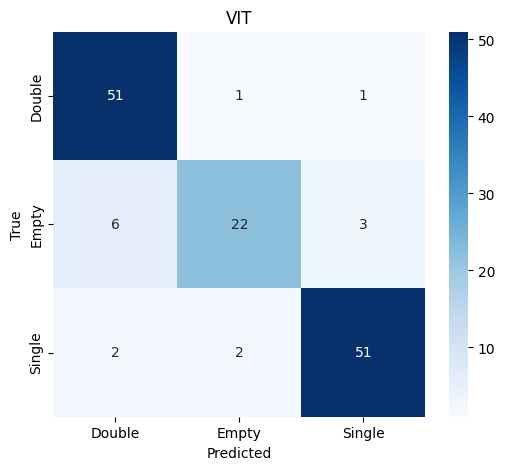


Confusion Matrix:
 [[51  1  1]
 [ 6 22  3]
 [ 2  2 51]]

Classification Report:
               precision    recall  f1-score   support

      Double       0.86      0.96      0.91        53
       Empty       0.88      0.71      0.79        31
      Single       0.93      0.93      0.93        55

    accuracy                           0.89       139
   macro avg       0.89      0.87      0.87       139
weighted avg       0.89      0.89      0.89       139


Training RandomForest with VIT features...
 RandomForest Accuracy: 82.01% | Precision: 0.84 | Recall: 0.79 | F1: 0.80
 Confusion matrix saved to /content/drive/MyDrive/confusion_matrices/VIT_RandomForest_confusion_matrix.png


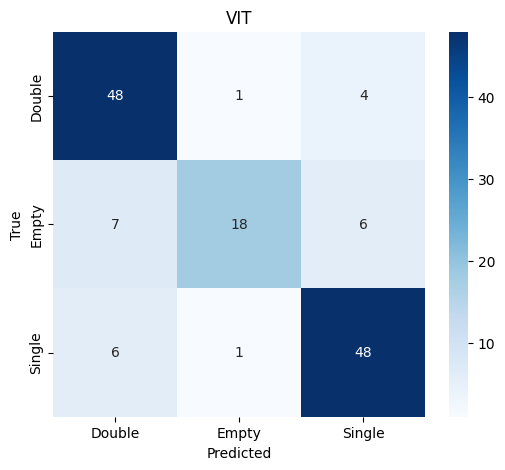


Confusion Matrix:
 [[48  1  4]
 [ 7 18  6]
 [ 6  1 48]]

Classification Report:
               precision    recall  f1-score   support

      Double       0.79      0.91      0.84        53
       Empty       0.90      0.58      0.71        31
      Single       0.83      0.87      0.85        55

    accuracy                           0.82       139
   macro avg       0.84      0.79      0.80       139
weighted avg       0.83      0.82      0.81       139


 Metrics Summary:

  Model    Classifier  Accuracy  Precision    Recall  F1-Score
0   VIT           SVM  0.884892   0.891310  0.860344  0.870538
1   VIT           MLP  0.892086   0.890560  0.866405  0.874567
2   VIT  RandomForest  0.820144   0.838157  0.786344  0.799182

 Metrics summary CSV saved to /content/drive/MyDrive/confusion_matrices/VIT_metrics_summary.csv


In [2]:
#  Install dependencies
!pip install transformers tensorflow scikit-learn opencv-python matplotlib seaborn --quiet

# Imports
from transformers import ViTFeatureExtractor, ViTModel
import torch
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, VGG16, MobileNetV3Large
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input as mobilenet_preprocess
from tensorflow.keras.models import Model

from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score,
                             recall_score, f1_score, classification_report)
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import cv2
from google.colab import drive

#  Mount Google Drive
drive.mount('/content/drive')

#  Dataset Path
dataset_path = '/content/drive/MyDrive/100_4strain_val_photos'

# Load Dataset
img_size = (224, 224)
X, y = [], []

for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(root, file)
            label = os.path.basename(root)
            img = cv2.imread(img_path)
            img = cv2.resize(img, img_size)
            X.append(img)
            y.append(label)

X = np.array(X)
y = np.array(y)

print("Total images:", len(X))
print("Classes:", np.unique(y))

#  Encode Labels and Split
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_val, y_train, y_val = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

#  Feature Extraction Functions
vit_feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
vit_model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')

def extract_vit_features(X_data):
    inputs = vit_feature_extractor(images=[cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in X_data], return_tensors="pt")
    with torch.no_grad():
        outputs = vit_model(**inputs)
    return outputs.last_hidden_state[:, 0, :].numpy()

def extract_features(model_name, X_data):
    if model_name == 'resnet':
        base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')
        X_data = resnet_preprocess(X_data.copy())
        model = Model(inputs=base_model.input, outputs=base_model.output)
        features = model.predict(X_data, batch_size=32, verbose=1)
    elif model_name == 'vgg16':
        base_model = VGG16(weights='imagenet', include_top=False, pooling='avg')
        X_data = vgg_preprocess(X_data.copy())
        model = Model(inputs=base_model.input, outputs=base_model.output)
        features = model.predict(X_data, batch_size=32, verbose=1)
    elif model_name == 'mobilenet':
        base_model = MobileNetV3Large(weights='imagenet', include_top=False, pooling='avg')
        X_data = mobilenet_preprocess(X_data.copy())
        model = Model(inputs=base_model.input, outputs=base_model.output)
        features = model.predict(X_data, batch_size=32, verbose=1)
    elif model_name == 'vit':
        features = extract_vit_features(X_data)
    else:
        raise ValueError("Invalid model name")
    return features

#  Folder to save confusion matrices
save_folder = '/content/drive/MyDrive/confusion_matrices'
os.makedirs(save_folder, exist_ok=True)

#  Choose the model: 'resnet' | 'vgg16' | 'mobilenet' | 'vit'
#model_choice = 'resnet'  # Change to 'vgg16', 'mobilenet', or 'vit' as needed
#model_choice = 'vgg16'
#model_choice = 'mobilenet'
model_choice = 'vit'

print(f"\nExtracting features using {model_choice.upper()}...")
train_features = extract_features(model_choice, X_train)
val_features = extract_features(model_choice, X_val)

#  Classifiers
classifiers = {
    "SVM": SVC(kernel='linear', probability=True),
    "MLP": MLPClassifier(hidden_layer_sizes=(256, 128), max_iter=500),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42)
}

# DataFrame to store metrics
metrics_list = []

#Training and Confusion Matrix Generation
for clf_name, clf in classifiers.items():
    print(f"\nTraining {clf_name} with {model_choice.upper()} features...")
    clf.fit(train_features, y_train)
    y_pred = clf.predict(val_features)

    # Metrics
    acc = accuracy_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_val, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_val, y_pred, average='macro', zero_division=0)

    print(f" {clf_name} Accuracy: {acc*100:.2f}% | Precision: {prec:.2f} | Recall: {rec:.2f} | F1: {f1:.2f}")

    #  Save metrics
    metrics_list.append({
        'Model': model_choice.upper(),
        'Classifier': clf_name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1
    })

    #  Confusion Matrix
    cm = confusion_matrix(y_val, y_pred)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title(f'{model_choice.upper()}')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    #  Save confusion matrix image
    filename = f'{model_choice.upper()}_{clf_name}_confusion_matrix.png'
    save_path = os.path.join(save_folder, filename)
    plt.savefig(save_path, bbox_inches='tight')
    print(f" Confusion matrix saved to {save_path}")

    plt.show()

    #  Print confusion matrix numbers
    print("\nConfusion Matrix:\n", cm)
    print("\nClassification Report:\n", classification_report(y_val, y_pred, target_names=label_encoder.classes_))

#  Metrics Summary DataFrame
metrics_df = pd.DataFrame(metrics_list)
print("\n Metrics Summary:\n")
print(metrics_df)

#Save metrics summary as CSV
metrics_csv_path = os.path.join(save_folder, f'{model_choice.upper()}_metrics_summary.csv')
metrics_df.to_csv(metrics_csv_path, index=False)
print(f"\n Metrics summary CSV saved to {metrics_csv_path}")


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
